# Graph coloring problem
Here we show how to solve the graph coloring problem using OpenJij, [JijModeling](https://www.ref.documentation.jijzept.com/jijmodeling/), and [JijModeling transpiler](https://www.ref.documentation.jijzept.com/jijmodeling-transpiler/). This problem is also mentioned in 6.1. Graph Coloring in [Lucas, 2014, "Ising formulations of many NP problems"](https://doi.org/10.3389/fphy.2014.00005).

## Overview of the graph coloring problem

In a graph coloring problem, we color two vertex edges on a given graph differently when they are on the same edge.
This problem is one of the famous NP-complete problems.

### Example

Consider an undirected graph with 6 vertices and some edges as shown below.

![](../../../assets/graph_coloring_01.png)

We can color this graph in three colors as follows:

![](../../../assets/graph_coloring_02.png)

No edge connects two vertices of the same color exist.

### Generalizing the problem

Now let us generalize the problem and express it in a mathematical model. Consider an undirected graph $G = (V, E)$ with $N$ colors so that vertices connected by edges do not overlap.
We consider coloring an undirected graph $G=(V, E)$ with $N$ colors, and introduce variables $x_{v, n}$ which are 1 if vertex $v$ is colored with $n$ and 0 otherwise.

#### Constraint
Vertices must be painted with one color, meaning that it is not allowed to paint one vertex with two colors.

$$
\sum_{n=0}^{N-1} x_{v, n} 
= 1 \quad (\forall v \in V) \tag{1}
$$

#### Objective function
The problem setup for the graph coloring problem requires that the vertices at both ends of every edge be painted with a different color.
This can be expressed as:

$$
\min \quad 
\sum_{n=0}^{N-1} \sum_{(uv) \in E} x_{u, n} x_{v, n} \tag{2}
$$

where $E$ is a set of edges on graph $G$.

| $x_{u,n}$ | $x_{v,n}$ | $x_{u,n}x_{v,n}$ |  
|-----------|-----------|------------------|
|     0     |     0     |         0        |
|     0     |     0     |         0        |
|     1     |     0     |         0        |
|     1     |     1     |         1        |

Since $x_{u,n}=1$ if vertex $u$ is colored by $n$ as defined above, $x_{u,n}x_{v,n}=1$ in the table above only when both $x_{u,n}$ and $x_{v,n}$ are 1, and 0 otherwise.
When two vertices on every edge have different colors, the value of this objective function is 0.
Therefore, this objective function is an indicator of the degree to which graph coloring has been achieved.

## Modeling by JijModeling

### Variables

Let us define the variables used in equations (1) and (2) as follows:

In [1]:
import jijmodeling as jm

# define variables
V = jm.Placeholder('V')
E = jm.Placeholder('E', dim=2)
N = jm.Placeholder('N')
x = jm.Binary('x', shape=(V, N))
n = jm.Element('i', (0, N))
v = jm.Element('v', (0, V))
e = jm.Element('e', E)

`V=jm.Placeholder('V')` represents the number of vertices. 
We denote `E=jm.Placeholder('E', dim=2)` a set of edges.
`N` is the number of colors.
We define a two-dimensional list of binary variables `x=jm.Binary('x', shape=(V, N))`, and we set the subscripts `n` and `v` used in the mathematical model.
`e` represents the variable for edges. `e[0]` and `e[1]` mean the vertex $u$ and $v$ on the edge, respectively.

### Constraint

Let us implement the constraint in equation (1).

In [2]:
# set problem
problem = jm.Problem('Graph Coloring')
# set one-hot constraint that each vertex has only one color
const = x[v, :]
problem += jm.Constraint('one-color', const==1, forall=v)

`x[v, :]` implements `Sum(n, x[v, n])` in a concise way.

### Objective function

Next, we implement the objective function of equation (2).
We write $\sum_n \sum_e$ as `Sum([n, e], ...)`.
JijModeling easily formulates the summation over nodes in edges.

In [3]:
# set objective function: minimize edges whose vertices connected by edges are the same color
sum_list = [n, e]
problem += jm.Sum(sum_list, x[e[0], n]*x[e[1], n])
problem

### Instance

Here we create a random graph with 12 vertices.

In [7]:
# set the number of vertices
inst_V = 12
# set the number of colors
inst_N = 4
# create a random graph
inst_G = nx.gnp_random_graph(inst_V, 0.4)
# get information of edges
inst_E = [list(edge) for edge in inst_G.edges]
instance_data = {'V': inst_V, 'N': inst_N, 'E': inst_E, 'G': inst_G}

In this code, the number of vertices in the graph and the number of colors are 12 and 4, respectively. 

### Undefined multiplier

This problem has one constraint, and we need to set the weight of that constraint.
We will set it to match the name we gave in the `Constraint` part earlier using a dictionary type.

In [10]:
# set multipliers
lam1 = 1.0
multipliers = {'one-color': lam1}

### Conversion to PyQUBO by JijModeling transpiler

JijModeling has executed all the implementations so far.
By converting this to [PyQUBO](https://pyqubo.readthedocs.io/en/latest/), it is possible to perform combinatorial optimization calculations using OpenJij and other solvers.

In [11]:
from jijmodeling.transpiler.pyqubo import to_pyqubo

# convert to pyqubo
pyq_model, pyq_chache = to_pyqubo(problem, instance_data, {})
qubo, bias = pyq_model.compile().to_qubo(feed_dict=multipliers)

The PyQUBO model is created by `to_pyqubo` with the `problem` created by JijModeling and the `instance_data` we set to a value as arguments.
Next, we compile it into a QUBO model that can be computed by OpenJij or other software.

### Optimization by OpenJij

This time, we will use OpenJij's simulated annealing to solve the optimization problem.
We set the `SASampler` and input the `qubo` of the QUBO model into that sampler to get the result of the calculation.

In [26]:
import openjij as oj
# set sampler
sampler = oj.SASampler(num_reads=100)
# solve problem
response = sampler.sample_qubo(qubo)

### Decoding and displaying the solution

Decode the returned results to facilitate analysis.

In [27]:
# decode solution
result = pyq_chache.decode(response)

From the result thus obtained, let us visualize the graph.
We prepare a graph using [NetworkX](https://networkx.org/). 

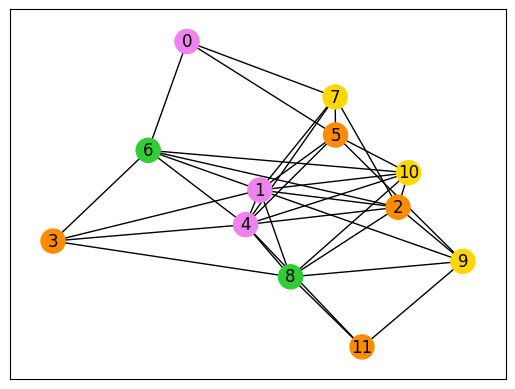

In [28]:
import matplotlib.pyplot as plt
# get indices of x = 1
indices, _, _ = result.lowest().record.solution['x'][0]
# get vertex number and color
vertices, colors = indices
# sort lists by vertex number
zip_lists = zip(vertices, colors)
zip_sort = sorted(zip_lists)
sorted_vertices, sorted_colors = zip(*zip_sort)
# initialize vertex color list
node_colors = [-1] * len(vertices)
# set color list for visualization
colorlist = ['gold', 'violet', 'limegreen', 'darkorange']
# set vertex color list
for i, j in zip(sorted_vertices, sorted_colors):
    node_colors[i] = colorlist[j]
# make figure
fig = plt.figure()
nx.draw_networkx(instance_data['G'], node_color=node_colors, with_labels=True)
# fig.savefig('graph_coloring.png')